In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import os
import random
from typing import List

import glob2 as glob
import tensorflow as tf
import tensorflow_addons as tfa
from azureml.core import Experiment, Workspace
from azureml.core.run import Run
from tensorflow.keras import callbacks, layers, models

sys.path.append(str(Path(os.getcwd()) / 'src'))

from config import CONFIG, DATASET_MODE_DOWNLOAD, DATASET_MODE_MOUNT
from constants import DATA_DIR_ONLINE_RUN, REPO_DIR
from model import create_base_cnn, create_head, load_base_cgm_model
from preprocessing import create_multiartifact_paths, tf_load_pickle, tf_augment_sample
from utils import download_dataset, get_dataset_path

In [2]:
# Make experiment reproducible
tf.random.set_seed(CONFIG.SPLIT_SEED)
random.seed(CONFIG.SPLIT_SEED)

# Get the current run.
run = Run.get_context()

DATA_DIR = REPO_DIR / 'data' if run.id.startswith("OfflineRun") else Path(".")
print(f"DATA_DIR: {DATA_DIR}")

# Offline run. Download the sample dataset and run locally. Still push results to Azure.
if run.id.startswith("OfflineRun"):
    print("Running in offline mode...")

    # Access workspace.
    print("Accessing workspace...")
    workspace = Workspace.from_config()
    experiment = Experiment(workspace, "training-junkyard")
    run = experiment.start_logging(outputs=None, snapshot_directory=None)

    dataset_name = CONFIG.DATASET_NAME_LOCAL
    dataset_path = get_dataset_path(DATA_DIR, dataset_name)
    download_dataset(workspace, dataset_name, dataset_path)

# Online run. Use dataset provided by training notebook.
else:
    print("Running in online mode...")
    experiment = run.experiment
    workspace = experiment.workspace

    dataset_name = CONFIG.DATASET_NAME

    # Mount or download
    if CONFIG.DATASET_MODE == DATASET_MODE_MOUNT:
        dataset_path = run.input_datasets["dataset"]
    elif CONFIG.DATASET_MODE == DATASET_MODE_DOWNLOAD:
        dataset_path = get_dataset_path(DATA_DIR_ONLINE_RUN, dataset_name)
        download_dataset(workspace, dataset_name, dataset_path)
    else:
        raise NameError(f"Unknown DATASET_MODE: {CONFIG.DATASET_MODE}")

DATA_DIR: /Users/markus/Development/cgm/cgm-ml/data
Running in offline mode...
Accessing workspace...
Accessing dataset...


In [3]:
# Get the QR-code paths.
dataset_scans_path = os.path.join(dataset_path, "scans")
print("Dataset path:", dataset_scans_path)
# print(glob.glob(os.path.join(dataset_scans_path, "*"))) # Debug
print("Getting QR-code paths...")
qrcode_paths = glob.glob(os.path.join(dataset_scans_path, "*"))
print("qrcode_paths: ", len(qrcode_paths))
assert len(qrcode_paths) != 0

# Shuffle and split into train and validate.
random.seed(CONFIG.SPLIT_SEED)
random.shuffle(qrcode_paths)
split_index = int(len(qrcode_paths) * 0.8)
qrcode_paths_training = qrcode_paths[:split_index]

qrcode_paths_validate = qrcode_paths[split_index:]
qrcode_paths_activation = random.choice(qrcode_paths_validate)
qrcode_paths_activation = [qrcode_paths_activation]

del qrcode_paths

# Show split.
print("Paths for training:")
print("\t" + "\n\t".join(qrcode_paths_training))
print("Paths for validation:")
print("\t" + "\n\t".join(qrcode_paths_validate))
print("Paths for activation:")
print("\t" + "\n\t".join(qrcode_paths_activation))

print(len(qrcode_paths_training))
print(len(qrcode_paths_validate))

assert len(qrcode_paths_training) > 0 and len(qrcode_paths_validate) > 0


def create_samples(qrcode_paths: List[str]) -> List[List[str]]:
    samples = []
    for qrcode_path in sorted(qrcode_paths):
        for code in CONFIG.CODES_FOR_POSE_AND_SCANSTEP:
            p = os.path.join(qrcode_path, code)
            new_samples = create_multiartifact_paths(p, CONFIG.N_ARTIFACTS)
            samples.extend(new_samples)
    return samples


paths_training = create_samples(qrcode_paths_training)
print(f"Samples for training: {len(paths_training)}")

paths_validate = create_samples(qrcode_paths_validate)
print(f"Samples for validate: {len(paths_validate)}")

paths_activate = create_samples(qrcode_paths_activation)
print(f"Samples for activate: {len(paths_activate)}")

Dataset path: /Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-95k/scans
Getting QR-code paths...
qrcode_paths:  4858
Paths for training:
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-95k/scans/1583740747-3retnv4b8d
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-95k/scans/1585004364-vhasc0gqv8
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-95k/scans/1585000209-pie0ud06af
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-95k/scans/1585011710-yugo07s6qn
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-95k/scans/1583997713-46z4p1qxmy
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-95k/scans/1585010651-245j6upbtq
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-95k/scans/1585014740-d09cuk62ce
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-95k/scans/1584749198-hep3fegoiv
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthmap-95k/scans/1585364605-jj09r4n9df
	/Users/markus/Development/cgm/cgm-ml/data/anon-depthm

In [4]:
# Create dataset for training.
paths = paths_training  # list
dataset = tf.data.Dataset.from_tensor_slices(paths)  # TensorSliceDataset  # List[ndarray[str]]
dataset = dataset.cache()
dataset = dataset.repeat(CONFIG.N_REPEAT_DATASET)
dataset = dataset.map(
    lambda path: tf_load_pickle(paths=path),
    tf.data.experimental.AUTOTUNE
)  # (240,180,5), (1,)

dataset = dataset.map(tf_augment_sample, tf.data.experimental.AUTOTUNE)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(CONFIG.SHUFFLE_BUFFER_SIZE)
dataset_training = dataset

# Create dataset for validation.
# Note: No shuffle necessary.
paths = paths_validate
dataset = tf.data.Dataset.from_tensor_slices(paths)
dataset_norm = dataset.map(lambda path: tf_load_pickle(path), tf.data.experimental.AUTOTUNE)
dataset_norm = dataset_norm.cache()
dataset_norm = dataset_norm.prefetch(tf.data.experimental.AUTOTUNE)
dataset_validation = dataset_norm
del dataset_norm

# Create dataset for activation
# paths = paths_activate
# dataset = tf.data.Dataset.from_tensor_slices(paths)
# dataset_norm = dataset.map(lambda path: tf_load_pickle(path), tf.data.experimental.AUTOTUNE)
# dataset_norm = dataset_norm.cache()
# dataset_norm = dataset_norm.prefetch(tf.data.experimental.AUTOTUNE)
# dataset_activation = dataset_norm
# del dataset_norm

# Note: Now the datasets are prepared.


def download_pretrained_model(output_model_fpath):
    print(f"Downloading pretrained model from {CONFIG.PRETRAINED_RUN}")
    previous_experiment = Experiment(workspace=workspace, name=CONFIG.PRETRAINED_EXPERIMENT)
    previous_run = Run(previous_experiment, CONFIG.PRETRAINED_RUN)
    previous_run.download_file("outputs/best_model.h5", output_model_fpath)


def get_base_model():
    if CONFIG.PRETRAINED_RUN:
        model_fpath = DATA_DIR / "pretrained/" / CONFIG.PRETRAINED_RUN / "best_model.h5"
        if not os.path.exists(model_fpath):
            download_pretrained_model(model_fpath)
        print(f"Loading pretrained model from {model_fpath}")
        base_model = load_base_cgm_model(model_fpath, should_freeze=CONFIG.SHOULD_FREEZE_BASE)
    else:
        input_shape = (CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH, 1)
        base_model = create_base_cnn(input_shape, dropout=CONFIG.USE_DROPOUT)  # output_shape: (128,)
    return base_model


# Create the base model
base_model = get_base_model()
assert base_model.output_shape == (None, 128)

# Create the head
head_input_shape = (128 * CONFIG.N_ARTIFACTS,)
head_model = create_head(head_input_shape, dropout=CONFIG.USE_CROPOUT)

# Implement artifact flow through the same model
model_input = layers.Input(
    shape=(CONFIG.IMAGE_TARGET_HEIGHT, CONFIG.IMAGE_TARGET_WIDTH, CONFIG.N_ARTIFACTS)
)

features_list = []
for i in range(CONFIG.N_ARTIFACTS):
    features_part = model_input[:, :, :, i:i + 1]
    features_part = base_model(features_part)
    features_list.append(features_part)

concatenation = tf.keras.layers.concatenate(features_list, axis=-1)
assert concatenation.shape.as_list() == tf.TensorShape((None, 128 * CONFIG.N_ARTIFACTS)).as_list()
model_output = head_model(concatenation)

model = models.Model(model_input, model_output)

Loading pretrained model from /Users/markus/Development/cgm/cgm-ml/data/pretrained/q3-depthmap-plaincnn-height-95k_1597988908_42c4ef33/best_model.h5


In [5]:
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

Epoch 1/5
33/33 - 155s - loss: 3663.5701 - mae: 60.1448
Epoch 2/5
33/33 - 153s - loss: 903.6098 - mae: 26.0989
Epoch 3/5
33/33 - 155s - loss: 9331.3262 - mae: 70.2418


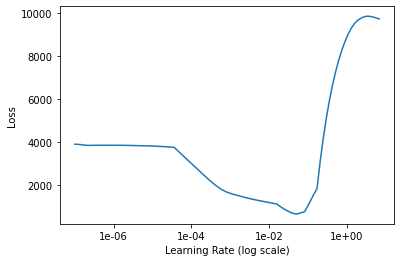

In [7]:
from lr_finder import LRFinder
lr_finder = LRFinder()
_ = model.fit(dataset_training.batch(CONFIG.BATCH_SIZE), epochs=5, callbacks=[lr_finder], verbose=2)
lr_finder.plot()

In [6]:
len(dataset_training) # 95k=2059

2059